### **Make a new dataset**
- target seq
- binder seq
- motif seq
- cluster

In [1]:
from transformers import T5Tokenizer, T5EncoderModel
import torch
import re
!pip install sentencepiece
import sentencepiece
import torch
from torch import nn
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.utils.data import DataLoader, Dataset

In [2]:
import os
os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/proteins/flamingo-ppi-gen/data_dump/per-residue-dataset/')

In [3]:
import pandas as pd
import re

def preprocess_snp_data(file_path):
    # Read the dataset
    snp_df = pd.read_csv(file_path)

    # Function to transform energy scores
    def transform_energy_scores(energy_scores):
        transformed_scores = []
        for score in energy_scores:
            # Replace sequences of spaces/newlines with a comma
            score = re.sub(r'[\s\n]+', ',', score)
            # Remove a comma after an opening square bracket
            score = re.sub(r'\[\s*,', '[', score)
            # Remove leading commas/whitespace
            score = re.sub(r'^[\s,]+', '', score)
            transformed_scores.append(score)
        return transformed_scores

    # Apply transformations
    snp_df['energy_scores'] = transform_energy_scores(snp_df['energy_scores'])
    snp_df['energy_scores_lengths'] = snp_df['energy_scores'].apply(
        lambda x: x.count(',') + 1 - (1 if x.startswith(',') else 0)
    )

    # Calculate lengths for other columns
    snp_df['peptide_source_RCSB_lengths'] = snp_df['peptide_source_RCSB'].apply(len)
    snp_df['protein_RCSB_lengths'] = snp_df['protein_RCSB'].apply(len)
    snp_df['protein_derived_seq_length'] = snp_df['protein_derived_sequence'].apply(len)
    snp_df['peptide_derived_seq_length'] = snp_df['peptide_derived_sequence'].apply(len)

    # Calculate matching lengths count (optional, depending on your needs)
    snp_df['matching_lengths_count'] = (snp_df['energy_scores_lengths'] == snp_df['peptide_derived_seq_length']).sum()

    return snp_df

# Applying the preprocessing pipeline to each dataset
test_snp = preprocess_snp_data('testing_dataset.csv')
train_snp = preprocess_snp_data('training_dataset.csv')
val_snp = preprocess_snp_data('validation_dataset.csv')


In [4]:
unique_seqs = pd.concat([train_snp['peptide_derived_sequence'], train_snp['protein_derived_sequence'],
                         test_snp['peptide_derived_sequence'], test_snp['protein_derived_sequence'],
                         val_snp['peptide_derived_sequence'], val_snp['protein_derived_sequence']]).unique()

In [5]:
max_length = max(len(seq) for seq in unique_seqs)
print(max_length)

984


In [6]:
import torch
import re
import pickle
from torch.utils.data import Dataset
from torch.nn.functional import pad

class ProteinInteractionDataset(Dataset):
    def __init__(self, dataframe):
        self.protT5_model = T5ForConditionalGeneration.from_pretrained("Rostlab/prot_t5_xl_bfd")
        self.protT5_tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd")
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        peptide_seq = self.dataframe.iloc[idx]['peptide_derived_sequence']
        protein_seq = self.dataframe.iloc[idx]['protein_derived_sequence']
        energy_scores = self.dataframe.iloc[idx]['energy_scores']

        max_length = 984

        # Process the energy_scores
        energy_scores = re.findall(r'-?\d+\.?\d*(?:e[-+]?\d+)?', energy_scores)
        energy_scores = [float(score) for score in energy_scores]
        energy_scores = one_hot_encode_energy_scores(energy_scores)
        energy_scores_padded = pad(torch.tensor(energy_scores), (0, max_length - len(energy_scores)), "constant", 0)

        return energy_scores_padded, peptide_seq, protein_seq

def one_hot_encode_energy_scores(scores):
        # Assuming 'scores' is a list of energy score values
        return [1 if score <= -1 else 0 for score in scores]

In [7]:
# Create datasets with tokenizer
train_dataset = ProteinInteractionDataset(train_snp)
test_dataset = ProteinInteractionDataset(test_snp)
val_dataset = ProteinInteractionDataset(val_snp)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [8]:
from torch.utils.data import DataLoader

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size)


### **Background Functions**

General

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
# from transformers import RobertaModel  # Assuming use of Hugging Face's transformer models

# Helper Functions
def exists(val):
    return val is not None

def set_module_requires_grad_(module, requires_grad):
    for param in module.parameters():
        param.requires_grad = requires_grad

def freeze_model_and_make_eval_(model):
    model.eval()
    set_module_requires_grad_(model, False)

# LayerNorm class
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gain = nn.Parameter(torch.ones(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gain * (x - mean) / (std + self.eps)

# Residual class
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# SwiGLU activation function
class SwiGLU(nn.Module):
    def forward(self, x):
        return F.silu(x[..., :x.shape[-1] // 2]) * x[..., x.shape[-1] // 2:]


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x)

class SwiGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim=-1)
        return F.silu(gate) * x



Main Perciever+Cross Attn

In [10]:
!pip install einops
!pip install einops-exts

In [11]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:4096'

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops_exts import rearrange_many, repeat_many

def exists(val):
    return val is not None

def FeedForward(dim, mult = 4):
    inner_dim = int(dim * mult)
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, inner_dim, bias = False),
        nn.GELU(),
        nn.Linear(inner_dim, dim, bias = False)
    )

class PerceiverAttention(nn.Module):
    def __init__(self, *, dim, concatenated_dim, dim_head=64, heads=8):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm_media = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)


    def forward(self, x, latents):
        x = self.norm_media(x)
        latents = self.norm_latents(latents)

        # print('x shape perciever attn:', x.shape)
        # print('latents shape perceiver attn', latents.shape)

        q = self.to_q(latents)
        # print('q shape:',q.shape)

        q = rearrange(q, 'b n (h d) -> b h n d', h=self.heads)
        q = q * self.scale


        kv_input = torch.cat((x, latents), dim=1)
        k, v = self.to_kv(kv_input).chunk(2, dim=-1)

        # print('k shape:',k.shape)
        # print('v shape:',v.shape)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.heads)

        # print('rearrangement in perceiver cross attn complete...')
        # print('q shape:',q.shape)
        # print('k shape:',k.shape)
        # print('v shape:',v.shape)

        sim = einsum('... i d, ... j d -> ... i j', q, k)
        attn = sim.softmax(dim=-1)
        out = einsum('... i j, ... j d -> ... i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class PerceiverResampler(nn.Module):
    def __init__(self, *, dim, depth, dim_head=64, heads=8, num_latents=64, concatenated_dim=2048):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PerceiverAttention(dim=dim, concatenated_dim=concatenated_dim, dim_head=dim_head, heads=heads),
                FeedForward(dim=dim)
            ]))

    def forward(self, x):
        latents = repeat(self.latents, 'n d -> b n d', b=x.shape[0])

        for attn, ff in self.layers:
            latents = attn(x, latents) + latents
            latents = ff(latents) + latents

        return latents

class MaskedCrossAttention(nn.Module):
    def __init__(self, *, dim, concatenated_dim=2048, dim_head=64, heads=8, only_attend_immediate_media=True):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)
        self.only_attend_immediate_media = only_attend_immediate_media

    def forward(self, x, media, media_locations=None):
        b, t, _ = x.shape
        _, m, _ = media.shape
        h = self.heads

        x = self.norm(x)
        q = self.to_q(x)
        q = rearrange(q, 'b n (h d) -> b h n d', h=h)

        # No need to reshape media as it's already 3D
        k, v = self.to_kv(media).chunk(2, dim=-1)
        k = rearrange(k, 'b n (h d) -> b h n d', h=h)
        v = rearrange(v, 'b n (h d) -> b h n d', h=h)

        q = q * self.scale
        sim = einsum('... i d, ... j d -> ... i j', q, k)

        if media_locations is not None:
            mask = media_locations.unsqueeze(1).unsqueeze(2)
            mask = rearrange(mask, 'b n -> b 1 n 1')
            sim = sim.masked_fill(mask == 0, float('-inf'))

        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)
        out = einsum('... i j, ... j d -> ... i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h=self.heads)

        return self.to_out(out)


class GatedCrossAttentionBlock(nn.Module):
    def __init__(self, *, dim, dim_head=64, heads=8, ff_mult=4, only_attend_immediate_media=True):
        super().__init__()
        self.attn = MaskedCrossAttention(dim=dim, concatenated_dim=2048, dim_head=dim_head, heads=heads, only_attend_immediate_media=only_attend_immediate_media)
        self.attn_gate = nn.Parameter(torch.tensor([0.]))
        self.ff = FeedForward(dim, mult=ff_mult)
        self.ff_gate = nn.Parameter(torch.tensor([0.]))

    def forward(self, x, media, media_locations=None):
        gate = self.attn_gate.tanh()
        x = self.attn(x, media, media_locations=media_locations) * gate + x
        x = self.ff(x) * self.ff_gate.tanh() + x
        return x



### **ProtFlamingo**
- input = tokenized target,binder & motif encoding
- protT5 embed tokenized AA seqs (text), motif emb (image)
- goal: complete binder seq (text completion)

In [12]:
import torch
import torch.nn as nn
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5EncoderModel

class ProtFlamingoLearnedEmbedding(nn.Module):
    def __init__(self, num_tokens, depth, dim_head=64, heads=8, ff_mult=4, cross_attn_every=3, perceiver_num_latents=64, perceiver_depth=2):
        super().__init__()

        # Set the device for the model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.motif_embedding_projection = nn.Embedding(2, 1024)  # Binary one-hot encoding to 1024 dimensions

        # Load ProtT5 model and tokenizer
        self.protT5_model = T5ForConditionalGeneration.from_pretrained("Rostlab/prot_t5_xl_bfd")
        self.protT5_tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd")
        self.protT5_encoder_model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc")

        # Access the decoder blocks from ProtT5 model
        self.decoder_blocks = self.protT5_model.decoder.block

        # Intersperse GatedCrossAttentionBlocks within the T5 decoder blocks
        self.layers = nn.ModuleList([])
        for i, block in enumerate(self.decoder_blocks):
            self.layers.append(block)
            if i % cross_attn_every == 0 and i != 0:
                self.layers.append(GatedCrossAttentionBlock(dim=self.protT5_model.config.d_model, dim_head=dim_head, heads=heads))

        self.perceiver_resampler = PerceiverResampler(dim=self.protT5_model.config.d_model, depth=perceiver_depth, dim_head=dim_head, heads=heads, num_latents=perceiver_num_latents)
        self.expand_seq_len = nn.Linear(dim_head, 984)

    def forward(self, target_seqs, binder_seqs, motif_encodings):
        MAX_LEN = 984
        all_logits_pred = []
        all_binder_tokenized_padded = []
        for i in range(len(target_seqs)):
            target_seq = target_seqs[i]
            binder_seq = binder_seqs[i]
            motif_one_hot = motif_encodings[i]
            motif_one_hot = motif_one_hot.unsqueeze(0)

            print('Target Seq:',target_seq)
            print('Motif Encoding Shape:', motif_one_hot.shape)

            target_embeddings, target_tokenized, target_attn_mask = self.generate_protT5_embeddings_tokens(target_seq)
            print('target_emb shape before padding:', target_embeddings.shape)
            binder_embeddings, binder_tokenized, binder_attn_mask = self.generate_protT5_embeddings_tokens(binder_seq)

            # Padding embeddings and tokenized sequences
            target_embeddings_padded = pad(target_embeddings, (0, 0, 0, MAX_LEN - target_embeddings.size(1)), "constant", 0)
            binder_embeddings_padded = pad(binder_embeddings, (0, 0, 0, MAX_LEN - binder_embeddings.size(1)), "constant", 0)

            target_tokenized_padded = pad(torch.tensor(target_tokenized, dtype=torch.long), (0, MAX_LEN - len(target_tokenized)), "constant", 0)
            binder_tokenized_padded = pad(torch.tensor(binder_tokenized, dtype=torch.long), (0, MAX_LEN - len(binder_tokenized)), "constant", 0)

            # target_tokenized_padded = target_tokenized_padded.unsqueeze(0)
            # binder_tokenized_padded = binder_tokenized_padded.unsqueeze(0)

            # Padding attention masks
            target_attn_mask_padded = pad(target_attn_mask, (0, MAX_LEN - target_attn_mask.size(1)), "constant", 0)
            binder_attn_mask_padded = pad(binder_attn_mask, (0, MAX_LEN - binder_attn_mask.size(1)), "constant", 0)

            motif_embeddings = self.motif_embedding_projection(motif_one_hot.long()) # this should be 1,984,1024
            # motif 1 != 2 mismatch is causing assertion error below!
            print("Motif Embeddings:",motif_embeddings)

            processed_motif_embeddings = self.perceiver_resampler(motif_embeddings)

            # Pass through layers (T5Blocks and GatedCrossAttentionBlocks)
            # Process through layers
            for layer in self.layers:
                if isinstance(layer, GatedCrossAttentionBlock):
                    print('starting gated cross attn block...')
                    print('input motif emb shape:', processed_motif_embeddings.shape)
                    print('input target emb shape:', target_embeddings_padded.shape)
                    target_embeddings_padded = layer(target_embeddings_padded, processed_motif_embeddings)
                    print('passed thru gated cross attn block...')
                    print("  Output from Gated Cross Attn Block is:", target_embeddings_padded.shape)
                    if isinstance(target_embeddings_padded, tuple):
                      print("  Output from Gated Cross Attn Block is a tuple. Taking first element.")
                      target_embeddings_padded = target_embeddings_padded[0]
                      print('output shape:', target_embeddings_padded.shape)
                else:
                    print('starting t5 block...')
                    print('input target emb shape:', target_embeddings_padded.shape)
                    print("input attn mask shape:",target_attn_mask_padded.shape)
                    target_embeddings_padded = layer(target_embeddings_padded, attention_mask=target_attn_mask_padded)

                    print('passed thru t5block...')
                    if isinstance(target_embeddings_padded, tuple):
                      print("  Output from T5 Decoder Block is a tuple. Taking first element.")
                      target_embeddings_padded = target_embeddings_padded[0]
                      print('output shape:', target_embeddings_padded.shape)

            logits = self.protT5_model.lm_head(target_embeddings_padded)
            print('Output Logits:',logits)
            print("Output Logits Shape:", logits.shape)

            all_logits_pred.append(logits)
            all_binder_tokenized_padded.append(binder_tokenized_padded)

        # Combine results from all batch elements
        batch_binder_tokenized_padded = torch.stack(all_binder_tokenized_padded, dim=0)
        batch_predicted_logits = torch.stack(all_logits_pred, dim=0)
        print('Batch pred logits:', batch_predicted_logits.shape)
        print('GT Binder Toks:', batch_binder_tokenized_padded.shape)

        return batch_binder_tokenized_padded, batch_predicted_logits

    def generate_protT5_embeddings_tokens(self, sequence):
        processed_seq = " ".join(list(re.sub(r"[UZOB]", "X", sequence)))
        ids = self.protT5_tokenizer(processed_seq, add_special_tokens=True, return_tensors="pt", padding='longest')
        input_ids = ids['input_ids'].to(device)
        seq_tok = input_ids.squeeze().tolist()
        attention_mask = ids['attention_mask'].to(device)

        with torch.no_grad():
            embedding_repr = self.protT5_encoder_model(input_ids=input_ids, attention_mask=attention_mask)
        seq_emb = embedding_repr.last_hidden_state
        # print('sequence embedding shape:',seq_emb.shape)

        return seq_emb,seq_tok,attention_mask

### **Initialize Model**

In [13]:
import torch
# Example parameters
num_tokens = 128 # protT5 vocab size
depth = 3  # Adjust based on model complexity and computational resources

model = ProtFlamingoLearnedEmbedding(
    num_tokens=num_tokens,
    depth=depth,
    dim_head=64,
    heads=8,
    ff_mult=4,
    cross_attn_every=2,
    perceiver_num_latents=64,
    perceiver_depth=2
)

# Assuming 'model', 'train_dataloader', 'val_dataloader', 'test_dataloader', and 'criterion' are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import torch

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### **Train Loop (One batch)**

In [14]:
import torch
import torch.nn as nn

def train_epoch_ce(model, data_loader, optimizer, device, clip_value=1.0):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Process only the first batch from the data loader
    one_hot_motifs, target_seqs, binder_seqs = next(iter(data_loader))

    one_hot_motifs = one_hot_motifs.float().to(device)

    # Zero the gradients
    optimizer.zero_grad()
    print("Target sequences:", target_seqs)
    print("One hot motifs:", one_hot_motifs)

    # Forward pass
    targets,logits = model(target_seqs, binder_seqs, one_hot_motifs)
    logits = logits.float()  # Convert logits to float
    targets = targets.long().to(device)  # Ensure targets are long and on the same device as logits

    print('ce loss calc begins...')
    print('input logits shape:',logits.view(-1, logits.size(-1)).shape) #984,128
    print('input target shape:',targets.view(-1).shape) #984
    # loss = nn.CrossEntropyLoss()(logits,targets)
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), targets.view(-1))
    # making sure the loss is run on 984,128 vs 984
    loss.backward()

    # Clip gradients: gradients are modified in place
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

    # Backward pass and optimize
    optimizer.step()

    total_loss += loss.item()

    average_loss = total_loss
    print(f"Training Loss: {average_loss:.4f}")
    return average_loss


Epoch 1/1
Target sequences: ('AEKLTLEAITGSAPLSGPTLTKPQIAPDGSRVTFLRGKDRDRNRLDLWEYDIASGQTRLLVDSSVVLPGEEVLSDEEKARRERQRIAALSGIVDYQWSPDGKALLFPLGGELYFYDLTKSGRDAVRKLTNGGGFATDPKISPKGGFVSFIRDRNLWAIDLASGKEVQLTRDGSDTIGNGVAEFVADEEMDRHTGYWWAPDDAAIAFARIDETPVPVQKRYEVYPDRTEVVEQRYPAAGDHNVRVQLGVIAPKTGARPRWIDLGKDPDIYLARVDWRDPQRLTFQRQSRDQKKIELIETTLTNGTQRTLVTETSTTWVPLHNDLRFLKDGRFLWSSERSGFEHLYVASEDGSTLTALTQGEWVVDSLLAIDEAAGLAYVSGTRDGATEAHVYAVPLSGGEPRRLTQAPGMHAATFARNASVFVDSWSSDTTLPQIELFKADGTKLATLLVNDVSDATHPYAKYRAAHQPTAYGTLTAADGTTPLHYSLIKPAGFDPKKQYPVVVFVYGGPAAQTVTRAWPGRSDSFFNQYLAQQGYVVFTLDNRGTPRRGAAFGGALYGKQGTVEVDDQLRGIEWLKSQAFVDPARIGVYGWSNGGYMTLMLLAKHDEAYACGVAGAPVTDWALYDTHYTERYMDLPKANEAGYREASVFTHVDGIGAGKLLLIHGMADDNVLFTNSTKLMSELQKRGTPFELMTYPGAKHGLRGSDLLHRYRLTEDFFARCLKP',)
One hot motifs: tensor([[1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

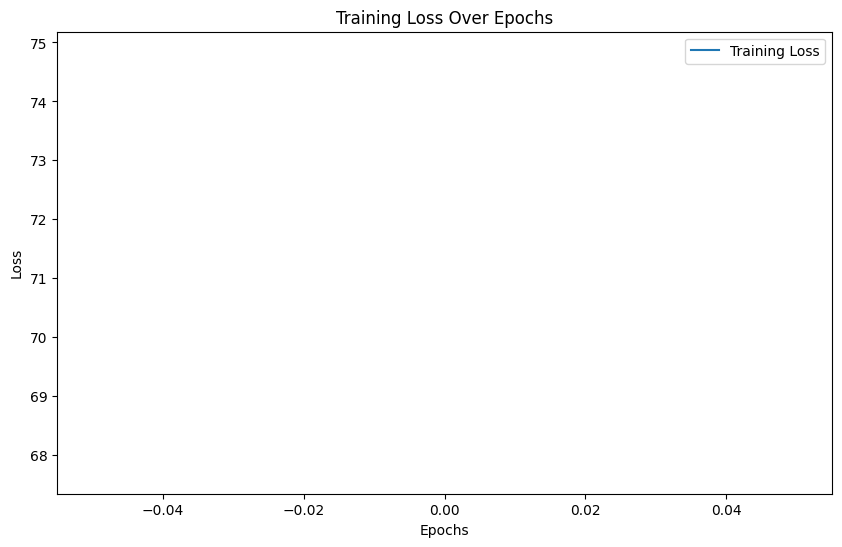

In [15]:
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Lists to store losses
train_losses = []

num_epochs = 1

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch_ce(model, train_dataloader, optimizer, device)
    train_losses.append(train_loss)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
